Loading and preparing Santa Fe laser data...

--- Starting Optical Cavity QRC Experiment ---
Parameters: 3 atoms, 5 photons. This may take 15-30 minutes.
Starting QuTiP mesolve for 8094 points...


c:\Users\Priyanshi\anaconda3\envs\qisk\Lib\site-packages\qutip\solver\solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


QuTiP simulation finished in 18.36 minutes.
Optical Cavity QRC Test NMSE: 0.135556

--- Starting Rydberg Atom QRC Experiment ---


Rydberg QRC Evolution: 100%|██████████| 2426/2426 [2:44:27<00:00,  4.07s/it]      


Epoch 0, Train Loss: 1.242997, Test Loss: 0.932572
Epoch 400, Train Loss: 1.055623, Test Loss: 0.829770
Epoch 800, Train Loss: 1.055623, Test Loss: 0.829770
Rydberg QRC Test NMSE: 0.996937

--- Training Classical Linear Model ---
Epoch 0, Train Loss: 1.008455, Test Loss: 0.778382
Epoch 400, Train Loss: 0.196792, Test Loss: 0.204137
Epoch 800, Train Loss: 0.196715, Test Loss: 0.202912
Epoch 1200, Train Loss: 0.196715, Test Loss: 0.202907
Epoch 1600, Train Loss: 0.196715, Test Loss: 0.202907

--- Training Classical Neural Network Model ---
Epoch 0, Train Loss: 1.017049, Test Loss: 0.646916
Epoch 400, Train Loss: 0.001325, Test Loss: 0.003659
Epoch 800, Train Loss: 0.000991, Test Loss: 0.003257
Epoch 1200, Train Loss: 0.001064, Test Loss: 0.003382
Epoch 1600, Train Loss: 0.000789, Test Loss: 0.002973
Epoch 2000, Train Loss: 0.001625, Test Loss: 0.004021
Epoch 2400, Train Loss: 0.000782, Test Loss: 0.002948
Epoch 2800, Train Loss: 0.000933, Test Loss: 0.002883
Linear Model Test NMSE: 0.243

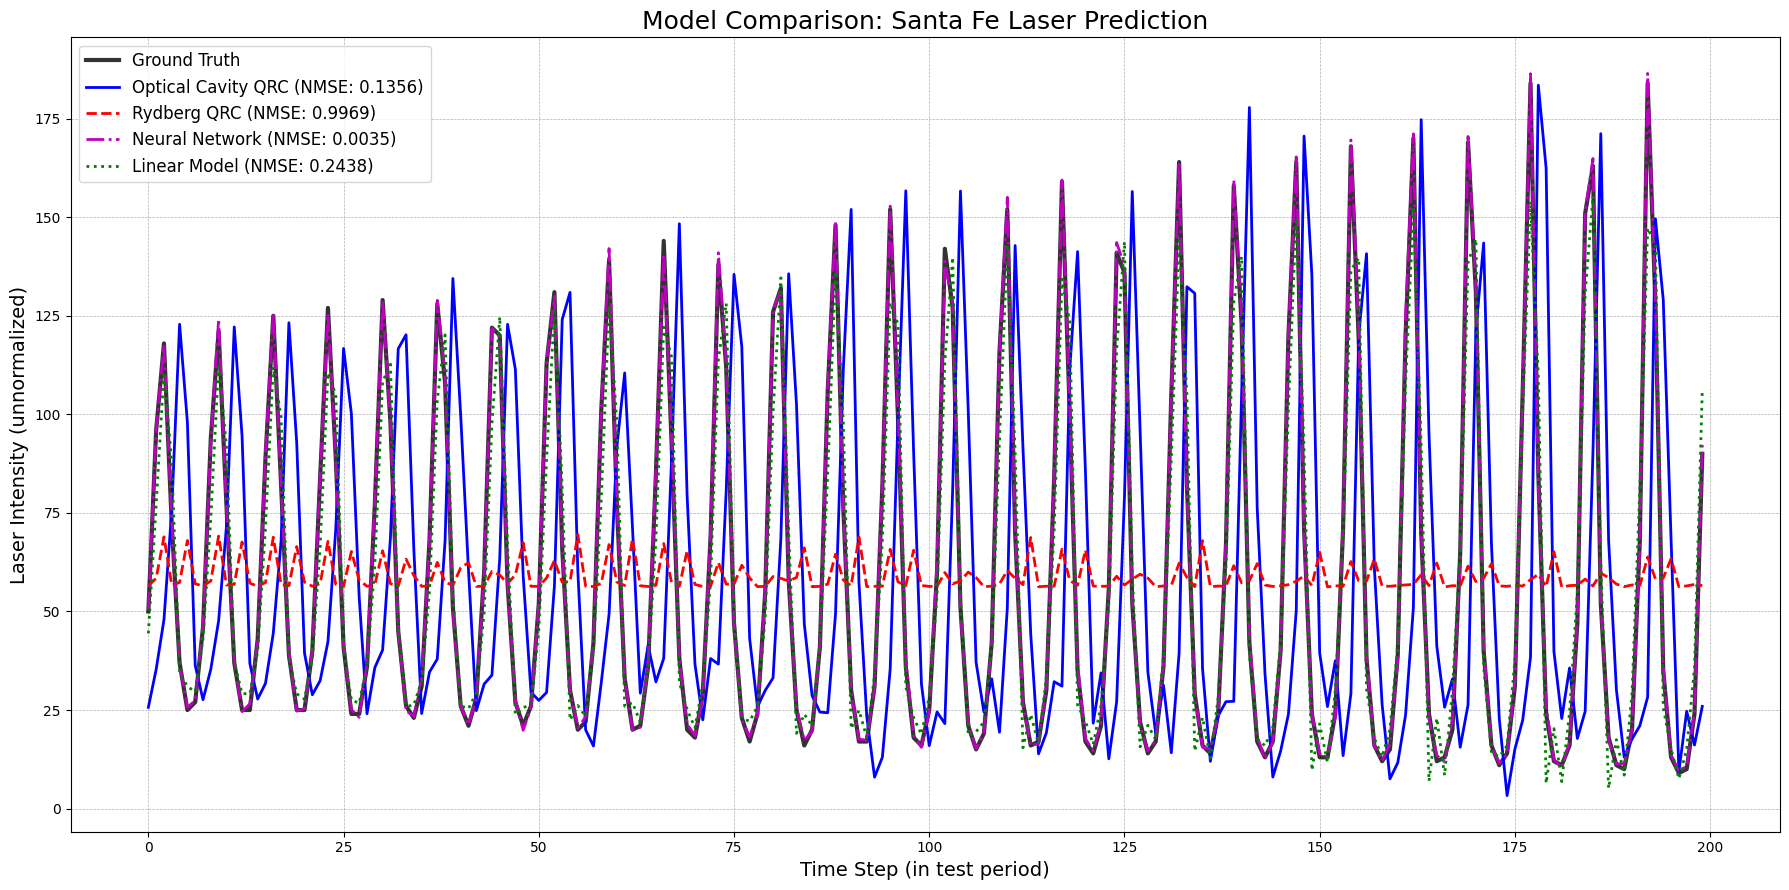

In [2]:
# =============================================================================
# MASTER SCRIPT: QRC Model Comparison for Santa Fe Laser Prediction
# =============================================================================
# This script compares four models:
# 1. Optical Cavity QRC (QuTiP model, 3 atoms, 7 photons)
# 2. Rydberg Atom QRC (PyTorch/SciPy model)
# 3. Classical Linear Model (PyTorch baseline)
# 4. Classical Neural Network (PyTorch baseline)
#
# REQUIRED LIBRARIES: qutip, torch, scipy, pandas, scikit-learn, matplotlib, tqdm
#
# The Optical Cavity simulation is the most demanding part and may take
# 15-30 minutes to complete.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# --- QuTiP & Sklearn Imports (for our model) ---
import qutip as qt
from sklearn.preprocessing import PolynomialFeatures

# --- PyTorch & SciPy Imports (for the other models) ---
import torch
from scipy.sparse import csr_matrix, kron
from scipy.integrate import solve_ivp
from tqdm import tqdm

# Set a global seed for reproducibility across all random processes
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# =============================================================================
# SECTION 1: OUR OPTICAL CAVITY QRC MODEL
# =============================================================================
def run_optical_cavity_qrc(input_signal, train_len, test_len, num_atoms, N_photons):
    """
    Runs the full Optical Cavity QRC experiment.
    """
    print("\n--- Starting Optical Cavity QRC Experiment ---")
    print(f"Parameters: {num_atoms} atoms, {N_photons} photons. This may take 15-30 minutes.")

    # --- 1. Define the Quantum System ---
    wc, g, kappa, epsilon = 40.0, 30.0, 10.0, 20.0
    wa_list = np.linspace(0, 40, num_atoms)

    def tensor_op(op, j, num_particles, particle_dims):
        op_list = [qt.qeye(dim) for dim in particle_dims]
        op_list[j] = op
        return qt.tensor(op_list)

    particle_dims = [N_photons] + [2] * num_atoms
    c = tensor_op(qt.destroy(N_photons), 0, num_atoms + 1, particle_dims)
    sm_list = [tensor_op(qt.sigmam(), i + 1, num_atoms + 1, particle_dims) for i in range(num_atoms)]
    sz_list = [tensor_op(qt.sigmaz(), i + 1, num_atoms + 1, particle_dims) for i in range(num_atoms)]

    H0 = wc * c.dag() * c
    for i in range(num_atoms):
        H0 += 0.5 * wa_list[i] * sz_list[i]
        H0 += g * (c.dag() * sm_list[i] + c * sm_list[i].dag())
    H1_operator = epsilon * 1j * (c - c.dag())
    scaled_kappa = kappa / (2 * num_atoms + 2)
    c_ops = [np.sqrt(scaled_kappa) * c]
    for i in range(num_atoms): c_ops.append(np.sqrt(scaled_kappa) * sm_list[i])

    # --- 2. Run the Simulation ---
    total_len = len(input_signal)
    times = np.arange(total_len)
    start_time = time.time()
    print(f"Starting QuTiP mesolve for {total_len} points...")

    psi0 = qt.tensor([qt.basis(N_photons, 0)] + [qt.basis(2,0)] * num_atoms)
    e_ops = [c + c.dag(), 1j * (c.dag() - c)]
    for i in range(num_atoms):
        sx = tensor_op(qt.sigmax(), i + 1, num_atoms + 1, particle_dims)
        sy = tensor_op(qt.sigmay(), i + 1, num_atoms + 1, particle_dims)
        e_ops.extend([sx, sy])
    H = [H0, [H1_operator, input_signal]]
    result = qt.mesolve(H, psi0, times, c_ops, e_ops)
    
    end_time = time.time()
    print(f"QuTiP simulation finished in {(end_time - start_time)/60:.2f} minutes.")

    # --- 3. Train with Polynomial Regression ---
    train_end_idx = train_len
    test_end_idx = train_len + test_len

    readouts = np.array(result.expect).T
    X_raw_train = readouts[0:train_end_idx]
    X_raw_test = readouts[train_end_idx:test_end_idx]

    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly_train = poly.fit_transform(X_raw_train)
    X_poly_test = poly.transform(X_raw_test)

    X_train_final = np.hstack([np.ones((X_poly_train.shape[0], 1)), X_poly_train])
    X_test_final = np.hstack([np.ones((X_poly_test.shape[0], 1)), X_poly_test])

    Y_train = input_signal[1 : train_end_idx + 1]
    Y_test = input_signal[train_end_idx + 1 : test_end_idx + 1]

    W = np.linalg.pinv(X_train_final) @ Y_train
    Y_predicted = X_test_final @ W

    nmse = np.mean((Y_test - Y_predicted.flatten())**2) / np.var(Y_test)
    print(f"Optical Cavity QRC Test NMSE: {nmse:.6f}")
    
    return Y_predicted, nmse

# =============================================================================
# SECTION 2: RYDBERG QRC & CLASSICAL MODELS (CODE PROVIDED BY USER)
# =============================================================================

# 1. Atom Positioning
class AtomList:
    def __init__(self, positions):
        self.positions = np.array(positions)
        self.n_atoms = len(positions)
    def distances(self):
        dist_matrix = np.zeros((self.n_atoms, self.n_atoms))
        for i in range(self.n_atoms):
            for j in range(i+1, self.n_atoms):
                dist = np.sqrt(np.sum((self.positions[i] - self.positions[j])**2))
                dist_matrix[i, j] = dist
                dist_matrix[j, i] = dist
        return dist_matrix

def generate_irregular_chain(n_sites, distances):
    if len(distances) != n_sites - 1: raise ValueError("Need n_sites-1 distances for n_sites atoms")
    positions = [(0, 0)]; y_pos = 0
    for d in distances: y_pos += d; positions.append((0, y_pos))
    return AtomList(positions)

# 2. Time-Dependent Pulse Shaping
class PiecewiseLinear:
    def __init__(self, clocks, values):
        if len(clocks) != len(values): raise ValueError("clocks and values must have same length")
        self.clocks = np.array(clocks); self.values = np.array(values)
    def __call__(self, t):
        if t <= self.clocks[0]: return self.values[0]
        if t >= self.clocks[-1]: return self.values[-1]
        idx = np.searchsorted(self.clocks, t) - 1
        t0, t1 = self.clocks[idx], self.clocks[idx+1]
        v0, v1 = self.values[idx], self.values[idx+1]
        alpha = (t - t0) / (t1 - t0)
        return v0 + alpha * (v1 - v0)

# 3. Fixed Operators for Quantum Evolution
def construct_single_site_operator(op, site_index, n_sites):
    I = csr_matrix(np.eye(2)); result = csr_matrix(np.eye(1))
    for i in range(n_sites):
        if i == site_index: result = kron(result, op, format="csr")
        else: result = kron(result, I, format="csr")
    return result

# 4. Fixed Time-Dependent Rydberg Hamiltonian
class RydbergTimeDependent:
    def __init__(self, atom_list, omega_func, detuning_func, V=1.0, phi_func=None):
        self.atom_list = atom_list; self.n_sites = atom_list.n_atoms; self.omega_func = omega_func
        self.detuning_func = detuning_func; self.phi_func = phi_func if phi_func is not None else lambda t: 0
        self.V = V; self.distances = atom_list.distances()
        self.sigma_x = csr_matrix(np.array([[0, 1], [1, 0]])); self.sigma_y = csr_matrix(np.array([[0, -1j], [1j, 0]]))
        self.sigma_z = csr_matrix(np.array([[1, 0], [0, -1]])); self.n_op = csr_matrix(np.array([[0, 0], [0, 1]]))
        self.sigma_x_ops = [construct_single_site_operator(self.sigma_x, i, self.n_sites) for i in range(self.n_sites)]
        self.sigma_y_ops = [construct_single_site_operator(self.sigma_y, i, self.n_sites) for i in range(self.n_sites)]
        self.sigma_z_ops = [construct_single_site_operator(self.sigma_z, i, self.n_sites) for i in range(self.n_sites)]
        self.n_ops = [construct_single_site_operator(self.n_op, i, self.n_sites) for i in range(self.n_sites)]
    def get_hamiltonian(self, t):
        omega_t = self.omega_func(t); detuning_t = self.detuning_func(t); phi_t = self.phi_func(t)
        H = csr_matrix((2**self.n_sites, 2**self.n_sites), dtype=complex)
        for i in range(self.n_sites):
            omega_i = omega_t[i] if isinstance(omega_t, (list, np.ndarray)) and i < len(omega_t) else omega_t
            detuning_i = detuning_t[i] if isinstance(detuning_t, (list, np.ndarray)) and i < len(detuning_t) else detuning_t
            if abs(omega_i) > 1e-10: H += 0.5 * omega_i * (np.cos(phi_t) * self.sigma_x_ops[i] + np.sin(phi_t) * self.sigma_y_ops[i])
            if abs(detuning_i) > 1e-10: H += -0.5 * detuning_i * self.sigma_z_ops[i]
        for i in range(self.n_sites):
            for j in range(i+1, self.n_sites):
                dist = self.distances[i, j]
                if dist > 1e-9:
                    interaction = self.V / (dist**6)
                    if abs(interaction) > 1e-10: H += interaction * self.n_ops[i] @ self.n_ops[j]
        return H

# 5. Quantum Evolution
class QuantumEvolution:
    def __init__(self, atol=1e-8, rtol=1e-8, use_gpu=True):
        self.atol = atol; self.rtol = rtol
        self.use_gpu = use_gpu and torch.cuda.is_available()
        self.device = torch.device("cuda" if self.use_gpu else "cpu")
    def evolve_state_torch(self, init_state, hamiltonian_func, t_span, t_eval=None):
        if t_eval is None: t_eval = np.linspace(t_span[0], t_span[1], 100)
        psi = torch.tensor(init_state.astype(complex), dtype=torch.cfloat, device=self.device)
        states = [psi.cpu().numpy()]; t = t_span[0]
        for i in range(1, len(t_eval)):
            dt = t_eval[i] - t; H_mid = hamiltonian_func(t + dt/2)
            if hasattr(H_mid, 'toarray'): H_mid = H_mid.toarray()
            H_t = torch.tensor(H_mid, dtype=torch.cfloat, device=self.device)
            k1 = -1j * torch.matmul(H_t, psi); k2 = -1j * torch.matmul(H_t, psi + 0.5 * dt * k1)
            k3 = -1j * torch.matmul(H_t, psi + 0.5 * dt * k2); k4 = -1j * torch.matmul(H_t, psi + dt * k3)
            psi = psi + (dt/6) * (k1 + 2*k2 + 2*k3 + k4); psi = psi / torch.norm(psi); t = t_eval[i]
            states.append(psi.cpu().numpy())
        return np.array(states)
    def evolve_state_ode(self, init_state, hamiltonian_func, t_span, t_eval=None):
        if self.use_gpu: return self.evolve_state_torch(init_state, hamiltonian_func, t_span, t_eval)
        else:
            init_state = init_state.flatten().astype(complex)
            def schrodinger_eq(t, psi): H_t = hamiltonian_func(t).toarray(); return -1j * (H_t @ psi)
            result = solve_ivp(schrodinger_eq, t_span, init_state, t_eval=t_eval, method='DOP853', atol=self.atol, rtol=self.rtol)
            if not result.success: print(f"ODE solver failed: {result.message}"); return None
            states = result.y.T; norms = np.linalg.norm(states, axis=1, keepdims=True)
            return states / norms

# 6. Readout for Quantum States
def construct_pauli_z(qubit_index, num_qubits): return construct_single_site_operator(csr_matrix(np.array([[1, 0], [0, -1]])), qubit_index, num_qubits)
def construct_pauli_zz(qubit_i, qubit_j, num_qubits): return construct_pauli_z(qubit_i, num_qubits) @ construct_pauli_z(qubit_j, num_qubits)
def expectation(state, operator): return np.real(np.vdot(state, operator @ state))

class EnhancedReadout:
    def __init__(self, n_sites, include_zz=True):
        self.n_sites = n_sites; self.readout_indices = list(range(n_sites)); self.include_zz = include_zz
        if include_zz: self.correlation_pairs = [(i, i+1) for i in range(n_sites-1)]
        else: self.correlation_pairs = []
    def measure_single_state(self, state, num_qubits):
        features = [expectation(state, construct_pauli_z(idx, num_qubits)) for idx in self.readout_indices]
        if self.include_zz: features.extend([expectation(state, construct_pauli_zz(i, j, num_qubits)) for i, j in self.correlation_pairs])
        return features
    def measure(self, evolved_results, num_qubits):
        features = []
        for state_history in evolved_results:
            if state_history is None:
                padding_size = len(self.readout_indices) + (len(self.correlation_pairs) if self.include_zz else 0)
                features.append([0] * padding_size)
            else:
                features.append(self.measure_single_state(state_history[-1], num_qubits))
        return np.array(features)

# 7. Rydberg QRC
class ImprovedQRC:
    def __init__(self, n_sites=10, encoding_type='global', omega_max=2*np.pi*1.5, V=1.0, duration=3.5, steps=10, atom_distances=None, use_gpu=True):
        self.n_sites = n_sites; self.encoding_type = encoding_type; self.omega_max = omega_max; self.V = V
        self.duration = duration; self.steps = steps
        if atom_distances is None:
            atom_distances = [8.3, 8.2, 8.2, 8.2, 8.1, 8.8, 8.2, 8.8, 8.8]
            if n_sites > len(atom_distances) + 1: atom_distances.extend([np.mean(atom_distances)] * (n_sites - 1 - len(atom_distances)))
            else: atom_distances = atom_distances[:n_sites-1]
        self.atoms = generate_irregular_chain(n_sites, atom_distances)
        self.evolution = QuantumEvolution(use_gpu=use_gpu); self.readout = EnhancedReadout(n_sites, include_zz=True)
    def encode_and_evolve(self, X):
        evolved_states_all = []
        for sample in tqdm(X, desc="Rydberg QRC Evolution"):
            init_state = np.zeros(2**self.n_sites, dtype=complex); init_state[0] = 1.0
            if self.encoding_type == 'global':
                clocks = np.linspace(0, self.duration, len(sample) + 1); values = np.append(sample, sample[-1])
                detuning_func = PiecewiseLinear(clocks, values); rabi_ramp = 0.05 * self.duration
                rabi_clocks = [0.0, rabi_ramp, self.duration - rabi_ramp, self.duration]
                rabi_values = [0.0, self.omega_max, self.omega_max, 0.0]; omega_func = PiecewiseLinear(rabi_clocks, rabi_values)
            else:
                detuning_values = np.zeros(self.n_sites); detuning_values[:len(sample)] = sample
                detuning_func = lambda t: detuning_values; omega_func = lambda t: self.omega_max
            hamiltonian = RydbergTimeDependent(self.atoms, omega_func, detuning_func, V=self.V)
            t_eval = np.linspace(0, self.duration, self.steps + 1)
            evolved_states = self.evolution.evolve_state_ode(init_state, hamiltonian.get_hamiltonian, (0, self.duration), t_eval)
            evolved_states_all.append(evolved_states)
        return self.readout.measure(evolved_states_all, self.n_sites)

# 8. Linear readout layer (using PyTorch)
class LinearReadout(torch.nn.Module):
    def __init__(self, input_size, output_size=1):
        super(LinearReadout, self).__init__(); self.linear = torch.nn.Linear(input_size, output_size)
    def forward(self, x): return self.linear(x)

# 9. Data loading (using pandas for robustness)
def load_laser_data(path="laser_train.csv"):
    try:
        df = pd.read_csv(path, header=None)
        return df.iloc[:,0].values
    except FileNotFoundError:
        print(f"FATAL ERROR: Data file '{path}' not found. Please download it and place it in the same directory."); exit()

# 10. Training function
def train_model(model, X_train, y_train, X_test, y_test, epochs=1000, lr=0.01, use_gpu=True):
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    model.to(device)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr); criterion = torch.nn.MSELoss()
    for epoch in range(epochs):
        model.train(); y_pred = model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        if epoch % 400 == 0:
            model.eval()
            with torch.no_grad():
                y_test_pred = model(X_test_tensor); test_loss = criterion(y_test_pred, y_test_tensor)
            print(f'Epoch {epoch}, Train Loss: {loss.item():.6f}, Test Loss: {test_loss.item():.6f}')
    return model

# 11. Main Rydberg QRC execution function
def run_rydberg_qrc_experiment(X_train, y_train, X_test, y_test, use_gpu=True):
    print("\n--- Starting Rydberg Atom QRC Experiment ---")
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    mean_X, std_X = np.mean(X_train), np.std(X_train)
    X_train_scaled = (X_train - mean_X) / std_X * 2.0 * np.pi
    X_test_scaled = (X_test - mean_X) / std_X * 2.0 * np.pi
    
    qrc = ImprovedQRC(n_sites=10, encoding_type='global', use_gpu=use_gpu)
    
    X_train_quantum = qrc.encode_and_evolve(X_train_scaled)
    X_test_quantum = qrc.encode_and_evolve(X_test_scaled)
    
    readout_model = LinearReadout(X_train_quantum.shape[1])
    readout_model = train_model(readout_model, X_train_quantum, y_train, X_test_quantum, y_test, epochs=1000, lr=0.01, use_gpu=use_gpu)
    
    readout_model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test_quantum, dtype=torch.float32).to(device)
        y_pred = readout_model(X_test_tensor).cpu().numpy()
    
    nmse = np.mean((y_test - y_pred.flatten())**2) / np.var(y_test)
    print(f"Rydberg QRC Test NMSE: {nmse:.6f}")
    return y_pred, nmse

# 12. Classical baselines for comparison
def run_classical_baselines(X_train, y_train, X_test, y_test):
    print("\n--- Training Classical Linear Model ---")
    linear_model = LinearReadout(X_train.shape[1])
    linear_model = train_model(linear_model, X_train, y_train, X_test, y_test, epochs=2000, lr=0.01, use_gpu=False)
    
    print("\n--- Training Classical Neural Network Model ---")
    nn_model = torch.nn.Sequential(
        torch.nn.Linear(X_train.shape[1], 50), torch.nn.ReLU(),
        torch.nn.Linear(50, 50), torch.nn.ReLU(),
        torch.nn.Linear(50, 1)
    )
    nn_model = train_model(nn_model, X_train, y_train, X_test, y_test, epochs=3000, lr=0.005, use_gpu=False)

    with torch.no_grad():
        linear_pred = linear_model(torch.tensor(X_test, dtype=torch.float32)).numpy()
        nn_pred = nn_model(torch.tensor(X_test, dtype=torch.float32)).numpy()
    
    linear_nmse = np.mean((y_test - linear_pred.flatten())**2) / np.var(y_test)
    nn_nmse = np.mean((y_test - nn_pred.flatten())**2) / np.var(y_test)
    
    print(f"Linear Model Test NMSE: {linear_nmse:.6f}")
    print(f"Neural Network Test NMSE: {nn_nmse:.6f}")
    return linear_pred, nn_pred, linear_nmse, nn_nmse

# =============================================================================
# SECTION 3: MAIN EXECUTION BLOCK
# =============================================================================
if __name__ == "__main__":
    # --- 1. Load and Prepare Data ONCE ---
    print("Loading and preparing Santa Fe laser data...")
    raw_data = load_laser_data('laser_train.csv')
    laser_data = raw_data[1000:]
    
    laser_data_mean = laser_data.mean()
    laser_data_std = laser_data.std()
    normalized_data = (laser_data - laser_data_mean) / laser_data_std

    window = 10
    X, y = [], []
    for i in range(len(normalized_data) - window):
        X.append(normalized_data[i:i+window])
        y.append(normalized_data[i+window])
    X, y = np.array(X), np.array(y)
    
    train_size = int(len(X) * 0.7)
    test_size = len(X) - train_size

    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]

    # --- 2. Run All Experiments ---
    
    # a) Our Optical Cavity QRC
    optical_qrc_pred, optical_qrc_nmse = run_optical_cavity_qrc(
        input_signal=normalized_data, 
        train_len=train_size, 
        test_len=test_size,
        num_atoms=3,      # Using 3 atoms for a reasonable runtime
        N_photons=5       # Using 5 photons for higher complexity
    )
    
    # b) Rydberg QRC
    use_gpu_flag = torch.cuda.is_available()
    rydberg_qrc_pred, rydberg_qrc_nmse = run_rydberg_qrc_experiment(
        X_train, y_train, X_test, y_test, use_gpu=use_gpu_flag
    )
    
    # c) Classical Baselines
    linear_pred, nn_pred, linear_nmse, nn_nmse = run_classical_baselines(X_train, y_train, X_test, y_test)
    
    # --- 3. De-normalize predictions for plotting ---
    y_test_denorm = (y_test * laser_data_std) + laser_data_mean
    optical_qrc_pred_denorm = (optical_qrc_pred * laser_data_std) + laser_data_mean
    rydberg_qrc_pred_denorm = (rydberg_qrc_pred * laser_data_std) + laser_data_mean
    linear_pred_denorm = (linear_pred * laser_data_std) + laser_data_mean
    nn_pred_denorm = (nn_pred * laser_data_std) + laser_data_mean

    # --- 4. Final Comparison Plot ---
    print("\n--- Generating Final Comparison Plot ---")
    plt.figure(figsize=(18, 9))
    plot_range = slice(100, 300)
    
    plt.plot(y_test_denorm[plot_range], 'k-', label='Ground Truth', linewidth=3, alpha=0.8)
    plt.plot(optical_qrc_pred_denorm.flatten()[plot_range], 'b', label=f'Optical Cavity QRC (NMSE: {optical_qrc_nmse:.4f})', linewidth=2)
    plt.plot(rydberg_qrc_pred_denorm.flatten()[plot_range], 'r', label=f'Rydberg QRC (NMSE: {rydberg_qrc_nmse:.4f})', linewidth=2, linestyle='--')
    plt.plot(nn_pred_denorm.flatten()[plot_range], 'm', label=f'Neural Network (NMSE: {nn_nmse:.4f})', linewidth=2, linestyle='-.')
    plt.plot(linear_pred_denorm.flatten()[plot_range], 'g', label=f'Linear Model (NMSE: {linear_nmse:.4f})', linewidth=2, linestyle=':')
    
    plt.title('Model Comparison: Santa Fe Laser Prediction', fontsize=18)
    plt.xlabel('Time Step (in test period)', fontsize=14)
    plt.ylabel('Laser Intensity (unnormalized)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig('final_comparison_plot.png')
    plt.show()